In [86]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [87]:
img_idx = 1

data = unpickle("../Data/cifar-10-batches-py/data_batch_1")
img = data[b'data'][img_idx].reshape(3, 32, 32)
label = data[b'labels'][img_idx]
labels = unpickle("../Data/cifar-10-batches-py/batches.meta")[b'label_names']
labels[label]

b'truck'

In [ ]:
import matplotlib.pyplot as plt

# Transpose from (3, 32, 32) to (32, 32, 3) for matplotlib
img_display = img.transpose(1, 2, 0)

plt.imshow(img_display)
plt.axis('off')
plt.title('CIFAR-10 Image')
plt.show()

In [88]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def add_gaussian_noise(image, sigma=25):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255)

def mrf_denoise_icm(noisy_img, lambda_smooth, iterations=10):
    """
    Implements MRF denoising using Iterative Conditional Modes (ICM).
    
    noisy_img: The input noisy image (Y)
    lambda_smooth: Weight of the smoothness prior (Higher = smoother/blurrier)
    iterations: How many times to sweep over the image
    """
    # 1. Initialize X (Latent Image) with Y (Noisy Image)
    # We use float to avoid overflow during calculations
    X = noisy_img.astype(float)
    h, w = X.shape
    
    # 2. Iterate
    for it in range(iterations):
        # Create a copy to update values synchronously (or update in-place for asynchronous)
        X_new = X.copy()
        
        for r in range(h):
            for c in range(w):
                # 3. Identify Neighbors (Handle boundaries)
                neighbors = []
                if r > 0: neighbors.append(X[r-1, c])   # Up
                if r < h-1: neighbors.append(X[r+1, c]) # Down
                if c > 0: neighbors.append(X[r, c-1])   # Left
                if c < w-1: neighbors.append(X[r, c+1]) # Right
                
                neighbor_sum = sum(neighbors)
                num_neighbors = len(neighbors)
                
                # 4. Apply Update Rule
                # Derivation: Minimizing (x - y)^2 + lambda * sum((x - n)^2)
                # Solution: x = (y + lambda * sum(neighbors)) / (1 + lambda * num_neighbors)
                
                y_val = noisy_img[r, c]
                
                # Note: The factor '2' from the derivative often cancels out or is absorbed 
                # into lambda, but here is the simplified weighted average form:
                numerator = y_val + (lambda_smooth * neighbor_sum)
                denominator = 1 + (lambda_smooth * num_neighbors)
                
                X_new[r, c] = numerator / denominator
        
        # Check for convergence (optional)
        diff = np.mean(np.abs(X_new - X))
        print(f"Iteration {it+1}/{iterations}, Change: {diff:.4f}")
        
        X = X_new

    return np.clip(X, 0, 255).astype(np.uint8)

# --- Usage Example ---
img = cv2.imread('../Data/01.png', 0)  # Load grayscale
noisy = add_gaussian_noise(img)
denoised = mrf_denoise_icm(noisy, lambda_smooth=1.5, iterations=5)

# Calculate PSNR as per your evaluation metrics
psnr = cv2.PSNR(img, denoised)
# print(f"PSNR: {psnr}")

Iteration 1/5, Change: 19.7147
Iteration 2/5, Change: 9.2360
Iteration 3/5, Change: 6.1349
Iteration 4/5, Change: 4.4477
Iteration 5/5, Change: 3.3653


Text(0.5, 1.0, 'Restored (MCMC)')

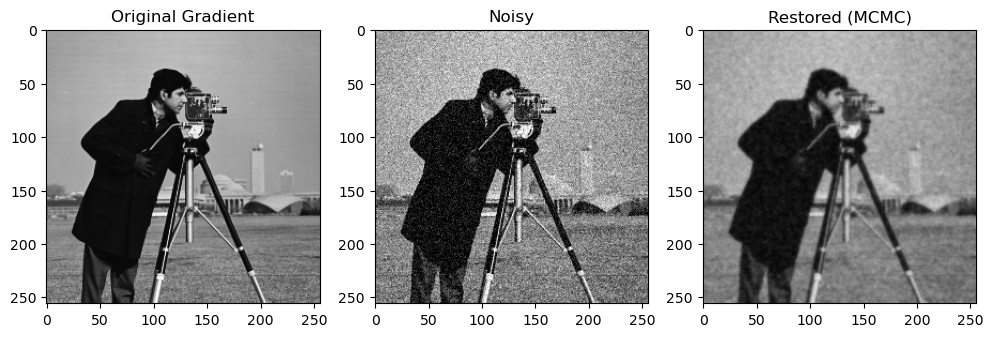

In [89]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray', vmin=0, vmax=255); ax[0].set_title("Original Gradient")
ax[1].imshow(noisy, cmap='gray', vmin=0, vmax=255); ax[1].set_title("Noisy")
ax[2].imshow(denoised, cmap='gray', vmin=0, vmax=255); ax[2].set_title("Restored (MCMC)")

/var/folders/ms/lvhkg1ns0z1bhb39n9bmf2s40000gn/T/ipykernel_7067/2180212315.py:61: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(-delta_E)
100%|██████████| 5000000/5000000 [00:25<00:00, 192318.98it/s]


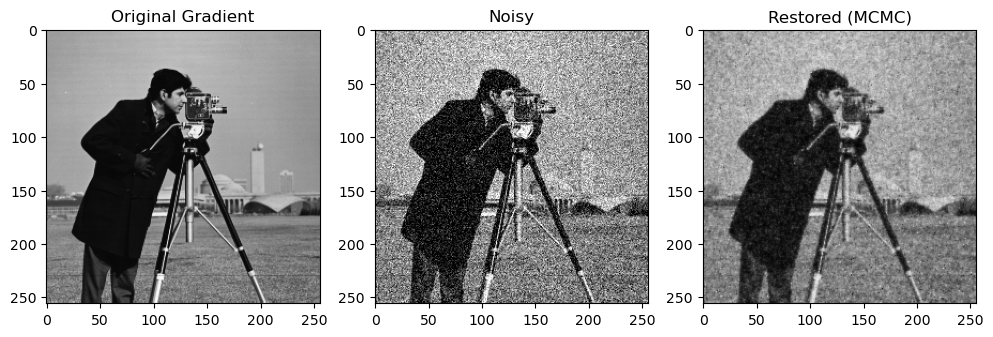

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_energy(val, neighbors, original_val, beta):
    """
    Calculates the 'Badness' of a pixel value.
    Lower energy = Better fit.
    """
    # 1. Smoothness (Difference from neighbors squared)
    neighbor_energy = 0
    for n_val in neighbors:
        neighbor_energy += (val - n_val)**2
        
    # 2. Fidelity (Difference from original data squared)
    data_energy = (val - original_val)**2
    
    return neighbor_energy + (beta * data_energy)

def mcmc_denoise_grayscale(noisy_img, iterations=500000, beta=0.01):
    """
    beta: Smoothness weight (Lowers contrast between neighbors)
    eta:  Data trust weight
    """
    current_img = noisy_img.copy().astype(float)
    h, w = current_img.shape
    
    pbar = tqdm(total = iterations)
    
    for step in range(iterations):
        # A. Pick Random Pixel
        i, j = np.random.randint(0, h), np.random.randint(0, w)
        
        # Get neighbors' values
        neighbors = []
        if i > 0: neighbors.append(current_img[i-1, j])
        if i < h-1: neighbors.append(current_img[i+1, j])
        if j > 0: neighbors.append(current_img[i, j-1])
        if j < w-1: neighbors.append(current_img[i, j+1])
        
        # B. Current State
        current_val = current_img[i, j]
        original_val = noisy_img[i, j]
        
        # C. Propose a new value (Random Walk)
        # We add a random number between -10 and +10 roughly
        proposal = current_val + np.random.normal(0, 2)
        
        # Clip to ensure valid range 0-255
        proposal = np.clip(proposal, 0, 255)

        # D. Calculate Energy of both options
        energy_current = calculate_energy(current_val, neighbors, original_val, beta)
        energy_proposal = calculate_energy(proposal, neighbors, original_val, beta)
        
        # E. Metropolis-Hastings Acceptance Step
        # If proposal has lower energy, delta_E is negative -> exp is > 1 -> Accept
        # If proposal has higher energy, exp is between 0 and 1 -> Chance to Accept
        delta_E = energy_proposal - energy_current
        
        acceptance_prob = np.exp(-delta_E)
        
        if np.random.rand() < acceptance_prob:
            current_img[i, j] = proposal
        
        pbar.update(1)

    return current_img

# --- RUN DEMO ---
# Create a gradient image
clean_img = img
# Add Gaussian Noise
size = img.shape[0]
noisy_img = clean_img + np.random.normal(0, 40, (size, size))
noisy_img = np.clip(noisy_img, 0, 255)

# Denoise
denoised_img = mcmc_denoise_grayscale(noisy_img, iterations=5000000, beta=1.5)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(clean_img, cmap='gray', vmin=0, vmax=255); ax[0].set_title("Original Gradient")
ax[1].imshow(noisy_img, cmap='gray', vmin=0, vmax=255); ax[1].set_title("Noisy")
ax[2].imshow(denoised_img, cmap='gray', vmin=0, vmax=255); ax[2].set_title("Restored (MCMC)")
plt.show()